<p align="center">
    <a href="https://bit.ly/3N9WvDB"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>
    <a href="https://bit.ly/3MyW8RW"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"/></a>
</p>

In [1]:
%%capture

# This cell only runs if you are running the notebook from Google Colab.
# Colab uses an old version of IPython (`5.5.0` from 2017) that is not 
# compatible with LineaPy. Hence, we need to upgrade it first. 
# You can ignore the message "Your session crashed for an unknown reason" 
# at the bottom of the screen. We triggered the runtime restart with `exit()`.

import IPython
import os
if (IPython.version_info[0] < 7) and any([k for k in dict(os.environ).keys() if k.startswith('COLAB_')]):
  !pip -q install ipython --upgrade
  # To load the updated ipython that we have just installed, 
  # we need to restart the runtime. The exit() command allows 
  # us to stop the current runtime, and executing the cell after 
  # it would restart the runtime.
  exit()
  # this is to allow for colab runtime to restart before trying to 
  # execute the next cell.

We now install and load LineaPy, along with other packages.

In [1]:
%%capture
!pip -q install lineapy==0.1.4 scikit-learn pandas matplotlib

In [2]:
%load_ext lineapy

# API Basics

In this tutorial, we will cover basic functionalities supported by `lineapy` using simple examples.

**Table of Contents**

- [Storing an artifact with save()](#Storing-an-artifact-with-save())
- [Listing artifacts with artifact_store()](#Listing-artifacts-with-artifact_store())
- [Retrieving an artifact with get()](#Retrieving-an-artifact-with-get())
- [Deleting an artifact with delete()](#Deleting-an-artifact-with-delete())
- [Using artifacts to build pipelines](#Using-artifacts-to-build-pipelines)

**What is an artifact?**

An artifact is anything that the data scientist is developing. It could be a model, a chart, a dataset, a feature. Any Python variable or serialization operation can be an artifact. In LineaPy, a LineaArtifact is both the value and the minimal code for computing the value. We will see in the rest of the notebook how we can automatically extract the minimal code for artifacts and create pipelines out of them with just two lines of code!


Below is a quick architecture diagram that indicates how the different APIs interact with the components in LineaPy. 


*   The import statement at the top automatically starts the tracking mechanism and initializes the database for storing metadata and artifact values if it hasn't been initialized previously
*   The `lineapy.save()` API creates LineaArtifacts and persists them to the database.
*   The `lineapy.get()` API enables retrieval of previously saved LineaArtifacts via `lineapy.save()`.
*   `lineapy.to_pipeline()` creates a pipeline containing >=1 LineaArtifact. The files associated with the pipeline include not only the code for computing the artifact but also the Python dependencies for the code and a Dockerfile to set up a container to run the pipeline with the right dependencies installed.

![LineaPy_artifact](https://github.com/LineaLabs/demos/blob/main/tutorial/lineapy_artifact.png?raw=1)

In [3]:
import os
import lineapy
import pandas as pd
import matplotlib.pyplot as plt

lineapy.options.set("is_demo", True) # For demo only

## Exploring data

Let's load the toy data to use.

In [4]:
# Load data
df = pd.read_csv("https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/tutorials/data/iris.csv")

In [5]:
# View data
df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


Now, we might be interested in seeing if the data reflects differences between iris types. Let's compare their petal traits.

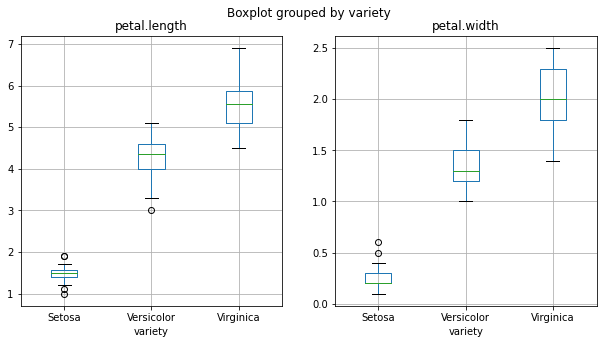

In [6]:
# Plot petal length/width by iris type
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
df.boxplot("petal.length", "variety", ax=ax[0])
df.boxplot("petal.width", "variety", ax=ax[1])
plt.show()

Overall, we observe noticeable differences between iris types, especially between Setosa and Virginica. Let's quantify differences between the two types.

In [7]:
# Calculate averages for Setosa
avg_length_setosa = df.query("variety == 'Setosa'")["petal.length"].mean()
avg_width_setosa = df.query("variety == 'Setosa'")["petal.width"].mean()

# Calculate averages for Virginica
avg_length_virginica = df.query("variety == 'Virginica'")["petal.length"].mean()
avg_width_virginica = df.query("variety == 'Virginica'")["petal.width"].mean()

# Calculate differences
diff_avg_length = avg_length_setosa - avg_length_virginica
diff_avg_width = avg_width_setosa - avg_width_virginica

In [8]:
# View result
print("Difference in average length:", diff_avg_length)
print("Difference in average width:", diff_avg_width)

Difference in average length: -4.09
Difference in average width: -1.7800000000000002


## Storing an artifact with `save()`

Say we are particularly interested in tracking the average length difference between Setosa and Virginica. For instance, we might want to use this variable later for population-level modeling of the two species.

The `save()` API allows us to store a variable's value *and* history as a data type called `LineaArtifact`. Note that `LineaArtifact` holds more than the final state of the variable &mdash; it also captures the complete development process behind the variable, which allows for full reproducibility. For more information about artifacts in LineaPy, please check the [Concepts](https://docs.lineapy.org/en/latest/fundamentals/concepts.html) section.

The API requires two arguments: the variable to save and the string name to save it as. It returns the saved artifact.

In [9]:
# Store the variable as an artifact
length_artifact = lineapy.save(diff_avg_length, "iris_diff_avg_length")

Folder /root/.lineapy/linea_pickles does not exist. Creating a new one.

In [10]:
# Check object type
print(type(length_artifact))

<class 'lineapy.api.api_classes.LineaArtifact'>


`LineaArtifact` object has two key methods:

- `.get_value()` returns value of the artifact, e.g., an integer or a dataframe
- `.get_code()` returns minimal essential code to create the value

Hence, for the current artifacts, we see:

In [11]:
# Check the value of the artifact
print(length_artifact.get_value())

-4.09


<div class="alert alert-info">

☝️ ☝️ ☝️ **[FEATURE] Retrieve artifact value** ☝️ ☝️ ☝️

</div>

In [12]:
# Check minimal essential code to generate the artifact
print(length_artifact.get_code())

import pandas as pd

df = pd.read_csv(
    "https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/tutorials/data/iris.csv"
)
avg_length_setosa = df.query("variety == 'Setosa'")["petal.length"].mean()
avg_length_virginica = df.query("variety == 'Virginica'")["petal.length"].mean()
diff_avg_length = avg_length_setosa - avg_length_virginica



<div class="alert alert-info">

☝️ ☝️ ☝️ **[FEATURE] Retrieve cleaned artifact code** ☝️ ☝️ ☝️

</div>

Note that irrelevant code has been stripped out (e.g., operations relating to `diff_avg_width` only).

<div class="alert alert-info">

**Note:** If you want, you can retrieve the artifact's full original code with `artifact.get_session_code()`.

**Warning:** Given that this demo uses a temporary runtime, LineaPy artifacts stored in the current session will not persist. If you want to continue exploring LineaPy, we recommend you install and use it on your own environment.

</div>

## Listing artifacts with `artifact_store()`

Of course, with time passing, we may not remember what artifacts we saved and under what names. The `artifact_store()` API allows us to see the list of all previously saved artifacts, like so:

In [13]:
# List all saved artifacts
lineapy.artifact_store()

iris_diff_avg_length:0 created on 2022-07-05 15:06:19.571205

<div class="alert alert-info">

☝️ ☝️ ☝️ **[FEATURE] Retrieve all artifacts** ☝️ ☝️ ☝️

</div>

Note that the artifact store records each artifact’s creation time, which means that multiple versions can be stored under the same artifact name. Hence, if we update and save `iris_diff_avg_length` artifact again, we get:


In [14]:
# Update and re-save the artifact
diff_avg_length_updated = diff_avg_length + 1
length_artifact = lineapy.save(diff_avg_length_updated, "iris_diff_avg_length")

In [15]:
# List all saved artifacts
lineapy.artifact_store()

iris_diff_avg_length:0 created on 2022-07-05 15:06:19.571205
iris_diff_avg_length:1 created on 2022-07-05 15:06:21.342971

## Retrieving an artifact with `get()`

We can retrieve any stored artifact using the `get()` API. This comes in handy when we work across multiple sessions/phases of a project (or even across different projects) as we can easily build on the previous work.

For example, say we have done other exploratory analyses and are finally starting our work on population-level modeling. This is likely done in a new Jupyter notebook (possibly in a different subdirectory) and we need an easy way to load artifacts from our past work. We can use the `get()` API for this.

The API takes the string name of the artifact as its argument and returns the corresponding artifact, like so:

In [16]:
# Retrieve a saved artifact
length_artifact_B = lineapy.get("iris_diff_avg_length")

By default, the `get()` API retrieves the latest version of the given artifact.

In [17]:
# Check artifact version
print(length_artifact_B.version)

1


In [18]:
# Check artifact value
print(length_artifact_B.get_value())

-3.09


In [19]:
# Check artifact code
print(length_artifact_B.get_code())

import pandas as pd

df = pd.read_csv(
    "https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/tutorials/data/iris.csv"
)
avg_length_setosa = df.query("variety == 'Setosa'")["petal.length"].mean()
avg_length_virginica = df.query("variety == 'Virginica'")["petal.length"].mean()
diff_avg_length = avg_length_setosa - avg_length_virginica
diff_avg_length_updated = diff_avg_length + 1



To retrieve a particular version of the artifact, say the very original one, we can specify the value of the optional argument `version`, like so:

In [20]:
# Retrieve an older version of the artifact
length_artifact_C = lineapy.get("iris_diff_avg_length", version=0)

In [21]:
# Check artifact version
print(length_artifact_C.version)

0


In [22]:
# Check artifact value
print(length_artifact_C.get_value())

-4.09


In [23]:
# Check artifact code
print(length_artifact_C.get_code())

import pandas as pd

df = pd.read_csv(
    "https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/tutorials/data/iris.csv"
)
avg_length_setosa = df.query("variety == 'Setosa'")["petal.length"].mean()
avg_length_virginica = df.query("variety == 'Virginica'")["petal.length"].mean()
diff_avg_length = avg_length_setosa - avg_length_virginica



## Deleting an artifact with `delete()`

With time passing, it is likely that the artifact store contains many artifacts, including some that we no longer need/want. We can use the `delete()` API to remove such undesired artifacts. For instance, we currently have two versions of `iris_diff_avg_length` artifact, like so:

In [24]:
# List all saved artifacts
lineapy.artifact_store()

iris_diff_avg_length:0 created on 2022-07-05 15:06:19.571205
iris_diff_avg_length:1 created on 2022-07-05 15:06:21.342971

Let's say we no longer need version `1`. We can remove it by calling the `delete()` API with the artifact name and version, as the following:

In [25]:
# Delete a specific artifact
lineapy.delete("iris_diff_avg_length", version=1)

Deleted Artifact: iris_diff_avg_length version: 1

If we check the artifact store again, we no longer see the artifact:

In [26]:
# List all saved artifacts
lineapy.artifact_store()

iris_diff_avg_length:0 created on 2022-07-05 15:06:19.571205

## Using artifacts to build pipelines

Say we are now also interested in using the average *width* difference in our population-level modeling, in which case we will store it as an artifact too:

In [27]:
# Store the width variable as an artifact too
width_artifact = lineapy.save(diff_avg_width, "iris_diff_avg_width")

Now consider the case where our source data (i.e. `iris.csv`) gets updated. Moreover, the update is not a one-time event; the data is planned to be updated on a regular basis as new samples arrive.

Since the `iris_diff_avg_length` and `iris_diff_avg_width` artifact were derived from the `iris.csv` data, this means that we need to rerun each artifact's code lest its value be stale. Given the recurring updates in the source data, we may want to build and schedule a pipeline to automatically rerun the code of both artifacts on a regular basis.

Having the complete development process captured in each artifact, LineaPy makes it easy for us to to turn these two artifacts into a deployable pipeline. For instance, [Airflow](https://airflow.apache.org/) is a popular tool for pipeline building and management, and we can turn the artifacts into a set of files that can be deployed as an Airflow DAG, like so:

In [28]:
# Build an Airflow pipeline with both length and width artifacts
lineapy.to_pipeline(
    artifacts=[length_artifact.name, width_artifact.name],
    pipeline_name="demo_pipeline",
    framework="AIRFLOW",
    output_dir="output/00_api_basics/demo_pipeline/",
)

Pipeline source generated in the directory: output/00_api_basics/demo_pipeline

Generated python module demo_pipeline.py

Generated Dockerfile demo_pipeline_Dockerfile

Generated requirements file demo_pipeline_requirements.txt

Added Airflow DAG named demo_pipeline_dag. Start a run from the Airflow UI or CLI.

PosixPath('output/00_api_basics/demo_pipeline')

where

- `artifacts` is the list of artifact names to be used for the pipeline
- `pipeline_name` is the name of the pipeline
- `output_dir` is the location to put the files for running the pipeline
- `framework` is the name of orchestration framework to use (currently supports `SCRIPTS` and `AIRFLOW`)

And we see the following files have been generated:

In [29]:
# Check the generated files for running the pipeline
os.listdir("output/00_api_basics/demo_pipeline/")

['demo_pipeline_dag.py',
 'demo_pipeline.py',
 'demo_pipeline_Dockerfile',
 'demo_pipeline_requirements.txt']

where

- `[PIPELINE-NAME].py` contains the artifact’s cleaned-up code packaged as a function
- `[PIPELINE-NAME]_dag.py` uses the packaged function to define the pipeline
- `[PIPELINE-NAME]_requirements.txt` lists dependencies for running the pipeline
- `[PIPELINE-NAME]_Dockerfile` contains commands to set up the environment to run the pipeline

Specifically, we have `demo_pipeline.py` looking as follows:

In [30]:
%cat output/00_api_basics/demo_pipeline/demo_pipeline.py

import pickle


def iris_diff_avg_length():

    import pandas as pd

    df = pd.read_csv(
        "https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/tutorials/data/iris.csv"
    )
    avg_length_setosa = df.query("variety == 'Setosa'")["petal.length"].mean()
    avg_length_virginica = df.query("variety == 'Virginica'")["petal.length"].mean()
    diff_avg_length = avg_length_setosa - avg_length_virginica
    length_artifact = pickle.dump(diff_avg_length, open("ZBW0iNt.pkl", "wb"))


def iris_diff_avg_width():

    import pandas as pd

    df = pd.read_csv(
        "https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/tutorials/data/iris.csv"
    )
    avg_width_setosa = df.query("variety == 'Setosa'")["petal.width"].mean()
    avg_width_virginica = df.query("variety == 'Virginica'")["petal.width"].mean()
    diff_avg_width = avg_width_setosa - avg_width_virginica
    width_artifact = pickle.dump(diff_avg_width, open("VOkvYIy.pkl", "wb"))


We can see that LineaPy used artifacts to automatically 1) clean up their code to retain only essential operations and 2) package the cleaned-up code into importable functions.

And we see `demo_pipeline_dag.py` automatically composing an Airflow DAG with these functions:

In [31]:
%cat output/00_api_basics/demo_pipeline/demo_pipeline_dag.py

import os

import demo_pipeline
from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from airflow.utils.dates import days_ago

default_dag_args = {"owner": "airflow", "retries": 2, "start_date": days_ago(1)}

dag = DAG(
    dag_id="demo_pipeline_dag",
    schedule_interval="*/15 * * * *",
    max_active_runs=1,
    catchup=False,
    default_args=default_dag_args,
)


iris_diff_avg_length = PythonOperator(
    dag=dag,
    task_id="iris_diff_avg_length_task",
    python_callable=demo_pipeline.iris_diff_avg_length,
)

iris_diff_avg_width = PythonOperator(
    dag=dag,
    task_id="iris_diff_avg_width_task",
    python_callable=demo_pipeline.iris_diff_avg_width,
)


These files, once placed in the location that Airflow expects (usually `dag/` under Airflow’s home directory), should let us immediately execute the pipeline from the UI or CLI.

For a more detailed illustration of pipeline building, please check [this](https://docs.lineapy.org/en/latest/guide/build_pipelines/index.html#) tutorial.

## Recap

In this tutorial, we learned basic functionalities of LineaPy including how to save, browse, and retrieve an artifact. We saw that a LineaPy artifact stores not only the value of a variable but also its full development code. This then helps to automate time-consuming, manual steps in a data science workflow such as code cleanup and pipeline building, hence helping data scientists move faster towards productionization and impact.